# Wk 3 discussion hw

In [31]:
# !conda update -n base conda
#!conda install -c conda-forge imbalanced-learn


In [32]:
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

In [33]:
zip_file = ZipFile('../../data/raw/forStudents.pkl.zip')
df = pd.read_pickle(zip_file.open('forStudents.pkl'))
df

,acquisition_type,snapshot_type,channel,evaluation_dt,vintage,is_app_approved,vantage3_score,bad,bad_v2,bad_balance,...,rtr5930,rtr7110,rtr7140,rtr7160,rtr7216,rtr7620,rtr8120,rtr8220,rtr8320,rowNumber
0,ORGANIC,FLOW_MODULARITY,OTHER,2021-08-04,202108,1,698.0,0.0,0.0,0.0,...,2.0,4.0,4.0,9.0,5.0,100.0,5.0,5.0,5.0,59486
1,ORGANIC,FLOW_MODULARITY,OTHER,2021-03-01,202103,1,731.0,0.0,0.0,0.0,...,30.0,2.0,2.0,130.0,12.0,100.0,4.0,4.0,4.0,2357
2,ORGANIC,FLOW_MODULARITY,OTHER,2021-02-26,202102,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90398
3,ORGANIC,FLOW_MODULARITY,OTHER,2021-06-04,202106,1,715.0,0.0,0.0,0.0,...,249.0,18.0,18.0,56.0,7.0,100.0,5.0,151.0,45.0,104654
4,ORGANIC,FLOW_MODULARITY,OTHER,2021-07-14,202107,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48707,ORGANIC,FLOW_MODULARITY,OTHER,2021-05-01,202105,1,732.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,131881
48708,ORGANIC,FLOW_MODULARITY,OTHER,2020-11-29,202011,1,705.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47197
48709,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-25,202104,1,722.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,2.0,167.0,86.0,29739
48710,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-10,202104,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89207


In [34]:
# Clean and imputation

df_clean = df[df['all0000'].notna()]
df_clean = df_clean[df_clean['bad'] != -1.0]
df_clean = df_clean[df_clean['is_app_approved'] == 1]
df_clean.drop(columns=['bad_v2','evaluation_dt','vintage', "vantage3_score", "bad_balance", "current_balance", "net_spend"], inplace=True)
described = df_clean["annual_income"].describe()
quartiles = list(described.iloc[4:7])

In [35]:
def assign_quartile(row):
    income = row["annual_income"]
    if income < quartiles[0]:
        return 0
    elif ((quartiles[0] < income) & (quartiles[1] >= income)):
        return 1
    elif ((quartiles[1] < income) & (quartiles[2] >= income)):
        return 2
    else:
        return 3

In [36]:
df_clean.apply(assign_quartile, axis=1).value_counts().sort_index()

0    10625
1    10546
2    10709
3    10667
dtype: int64

In [37]:
df_clean['income_quartile'] = df_clean.apply(assign_quartile, axis=1)

In [38]:
dfs = []
for i in range(4):
    quartile = df_clean.loc[df_clean["income_quartile"] == i]
    dfs.append(quartile.fillna(quartile.mean()))
    
df_clean = pd.concat(dfs)

temp = df_clean.isna().sum().to_frame()
temp[temp[0] != 0]

df_clean.drop(columns=['all9230', 'all9240', 'all9249', 'all9280'], inplace=True)
df_clean = df_clean.fillna(df_clean.mean())

In [39]:
# Categorical

def process_categorical_data(dataset):
    """ One hot encodes all of the categorial columns of the dataset.  Removes the original columns """
    # select categorical data
    categorical_data = dataset.select_dtypes('object')
    
    enc = OneHotEncoder(handle_unknown='ignore')
    
    ohe_data = enc.fit_transform(categorical_data).toarray()
    column_names = enc.get_feature_names(categorical_data.columns)
    
    add = dataset.select_dtypes(exclude='object')
    added = pd.DataFrame(ohe_data,columns=column_names).astype(int)
    
    add.reset_index(drop = True, inplace= True)
    added.reset_index(drop = True, inplace= True)
    X = pd.concat([add, 
               added], axis=1)
    print(X.shape)
    return X

df_clean = process_categorical_data(df_clean)
df_clean

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(42547, 887)


,is_app_approved,bad,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,0.0,15171,10.0,8.000000,8.000000,0.0,9.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,20000,3.0,4.165954,5.237061,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,7000,6.0,4.165954,5.237061,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,18000,3.0,1.000000,1.000000,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,30000,6.0,4.165954,5.237061,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,1,0.0,125000,12.0,9.305257,11.139763,0.0,11.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42543,1,0.0,101000,60.0,21.000000,11.139763,0.0,43.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42544,1,0.0,145000,53.0,9.305257,11.139763,0.0,52.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42545,1,0.0,72000,7.0,9.305257,11.139763,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# Imbalance dataset

# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X = df_clean.drop('bad', axis=1)
# y = df_clean['bad'].astype(int)
# counter = Counter(y)
# print(counter)
# X, y = oversample.fit_resample(X, y)
# counter = Counter(y)
# print(counter)

## Train logistic regression model

In [41]:
# Splitting Dataset
from sklearn.linear_model import LogisticRegression
X = df_clean.drop('bad', axis=1)
y = df_clean[['bad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(penalty='none').fit(X_train,y_train)
y_pred =clf.predict(X_test)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

### Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

NameError: name 'y_pred' is not defined

### Precision, recall, f1 score, accuracy metrics

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined

### Plotting ROC on train/test + train/test auc scores

In [44]:
clf.predict_proba(X_test).T[1].shape


NameError: name 'clf' is not defined

NameError: name 'clf' is not defined

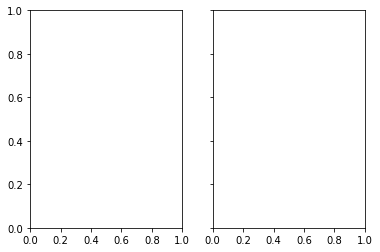

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 2, sharey=True)

logit_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# plt.figure()
axes[0].plot(fpr, tpr, label='(test_AUC = %0.2f)' % logit_roc_auc)
axes[0].plot([0, 1], [0, 1],'r--')
# axes[0].xlim([0.0, 1.0])
# axes[0].ylim([0.0, 1.05])
# axes[0].xlabel('False Positive Rate')
# axes[0].ylabel('True Positive Rate')
axes[0].title.set_text('Receiver operating characteristic')
axes[0].legend(loc="lower right")
# axes[0].savefig('Log_ROC')
# axes[0].show()

logit_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.figure()
axes[1].plot(fpr, tpr, label='(train_AUC = %0.2f)' % logit_roc_auc)
axes[1].plot([0, 1], [0, 1],'r--')
# axes[1].xlim([0.0, 1.0])
# axes[1].ylim([0.0, 1.05])
# axes[1].xlabel('False Positive Rate')
# axes[1].ylabel('True Positive Rate')
axes[1].title.set_text('Receiver operating characteristic')
axes[1].legend(loc="lower right")
# axes[1].savefig('Log_ROC')
# axes[1].show()
fig.tight_layout()

plt.show()

### AUC on worst scoring 30%

In [46]:
logit_roc_auc = roc_auc_score(y_test, y_pred, max_fpr = 0.3)

print(f'AUC on worst scoring 30%: {logit_roc_auc}')

NameError: name 'y_pred' is not defined

### Plotting reliability diagram on train/test + ece score

In [47]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_train, clf.predict_proba(X_train)[:,1], n_bins=10, normalize = True)

plt.plot([0, 1], [0, 1],'r--')
plt.plot(prob_true, prob_pred)
plt.show()


ece = np.sum(np.abs(prob_true - prob_pred) * ((len(y_test)/10) / len(y_test)))
print(ece)

NameError: name 'clf' is not defined

In [48]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, clf.predict_proba(X_test)[:,1], n_bins=10)

plt.plot([0, 1], [0, 1],'r--')
plt.plot(prob_true, prob_pred)
plt.show()


ece = np.sum(np.abs(prob_true - prob_pred) * ((len(y_test)/10) / len(y_test)))
print(ece)

NameError: name 'clf' is not defined

### Compute loss 

In [49]:
from sklearn.metrics import log_loss

print(f'log loss: {log_loss(y_test, clf.predict_proba(X_test))}')

NameError: name 'clf' is not defined

### Compute dollar loss prevented

In [50]:
# dollar loss prevented
X_test['predicted_bad'] = y_pred
X_test[(y_test == 1) & (y_test == y_pred)]['bad_balance'].sum().round(2)

NameError: name 'y_pred' is not defined

#### Discuss with your group some pros/cons of different evaluation metrics



Accuracy:
Pros: gives us a general idea of how our model is performing based on the overall correctness of predictions
Cons: does not account for class imbalance, if our model guessed that nobody would default then it would be ~90% accurate, does not account for dollar loss due to defaulting

Precision / Recall / F1-score:
Pros: better than accuracy, precision and recall measure the performance for each class independently, f1 score combines precision and recall
Cons: do not account for dollar loss due to defaulting, not as relevant to business stakeholders

dollar loss prevented:
Pros: accounts for dollar loss due to defaulting, extremely relevant to business stakeholders
Cons: the baseline we used was giving everyone a loan, this may not be realistic (solution would be to use this logistic regression as a baseline and compare the dollar loss in our future models to this model)


# Week 4-6 starts here:

### Brainstorm with your team some ideas of new features you can create.

We are going to attempt to reduce the dimensionality of our features. PCA can remove correlated features, reduce overfitting, and thus improve the accuracy of our ML model.

In [51]:
df_clean

,is_app_approved,bad,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,0.0,15171,10.0,8.000000,8.000000,0.0,9.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,20000,3.0,4.165954,5.237061,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,7000,6.0,4.165954,5.237061,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,18000,3.0,1.000000,1.000000,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,30000,6.0,4.165954,5.237061,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,1,0.0,125000,12.0,9.305257,11.139763,0.0,11.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42543,1,0.0,101000,60.0,21.000000,11.139763,0.0,43.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42544,1,0.0,145000,53.0,9.305257,11.139763,0.0,52.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42545,1,0.0,72000,7.0,9.305257,11.139763,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
# TODO: balance df_clean
df_clean_0 = df_clean[df_clean['bad'] == 0.0]
df_clean_1 = df_clean[df_clean['bad'] == 1.0]

df_clean_0_sample = df_clean_0.sample(n=len(df_clean_1), replace=False, random_state = 42)
df_clean_balanced = pd.concat([df_clean_0_sample, df_clean_1])

len(df_clean_balanced) # should be 3693 * 2 = 7386

7386

In [53]:
def model_evaluator(data):
    X = data.drop('bad', axis=1)
    y = data['bad'].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = LogisticRegression(penalty='none').fit(X_train,y_train)
    y_pred =clf.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    X_test['predicted_bad'] = y_pred
#     print("Dollar Loss: " + str(X_test[(y_test == 1) & (y_test == y_pred)]['bad_balance'].sum().round(2)))

In [54]:
model_evaluator(df_clean_balanced)

[[510 604]
 [319 783]]
              precision    recall  f1-score   support

           0       0.62      0.46      0.52      1114
           1       0.56      0.71      0.63      1102

    accuracy                           0.58      2216
   macro avg       0.59      0.58      0.58      2216
weighted avg       0.59      0.58      0.58      2216



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [55]:
X = df_clean_balanced.drop('bad', axis=1)
y = df_clean_balanced['bad'].astype(int)

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_data = pd.DataFrame(scaler.transform(X))

In [57]:
scaled_data

,0,1,2,3,4,5,6,7,8,9,...,876,877,878,879,880,881,882,883,884,885
0,0.0,-0.063132,-0.271052,-0.450030,-0.565297,-0.094785,-0.392699,-0.02716,-0.22507,-0.203263,...,-0.04034,-0.1328,4.098486,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
1,0.0,-0.057225,-0.723091,-0.450030,-0.565297,-0.094785,-0.682158,-0.02716,-0.22507,-0.607925,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
2,0.0,-0.026283,-0.271052,-1.298225,0.233685,-0.094785,-0.199727,-0.02716,-0.22507,0.066512,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
3,0.0,-0.026521,0.271395,-0.483818,0.233685,-0.094785,0.282705,-0.02716,-0.22507,0.740950,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
4,0.0,-0.034613,-0.451868,-0.280217,-0.616574,-0.094785,-0.392699,-0.02716,-0.22507,-0.338150,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7381,0.0,0.027272,0.361803,1.144995,0.897553,-0.094785,0.379192,-0.02716,-0.22507,0.201400,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
7382,0.0,-0.002480,0.542618,0.126987,-0.183967,-0.094785,-0.585672,-0.02716,-0.22507,-0.607925,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
7383,0.0,0.033223,1.265881,0.534190,0.248641,-0.094785,1.440542,-0.02716,-0.22507,0.606062,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034
7384,0.0,-0.009621,0.180987,-0.076615,-0.400271,-0.094785,0.282705,-0.02716,-0.22507,0.336287,...,-0.04034,-0.1328,-0.243993,-0.072858,-0.158946,-0.053398,-0.152097,-0.130672,-0.088965,-0.04034


In [58]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
pca = PCA(n_components=50)
pca.fit(scaled_data)
transformed_data = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame(transformed_data)

In [59]:
pca_data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-7.177256,-4.512930,4.265165,2.081165,-2.684958,-1.721774,-2.413139,4.802515,-0.447677,-1.828031,...,0.523060,-0.615477,0.694305,0.376286,-1.562722,0.848845,0.863605,-0.081725,1.492355,-0.889937
1,-8.489437,-0.076108,4.600491,1.496669,1.943937,-1.350314,-0.997757,3.757005,-1.257623,-3.831402,...,0.176558,1.114303,0.147614,-0.491531,1.697974,0.354410,0.300866,0.776204,-0.495788,0.160969
2,-4.528945,2.689593,-1.525833,3.402562,-10.939204,32.022132,1.318513,4.352364,-2.980136,-0.087603,...,2.811924,-3.962683,4.865532,-0.973021,1.013657,-7.409188,-8.633739,5.965685,1.930240,2.567556
3,8.412768,13.358951,-0.496734,0.207961,2.105100,0.205442,3.957855,-4.745021,-5.984153,-5.472725,...,-1.866852,2.253865,0.401529,1.865700,-0.323210,-3.739230,0.166171,3.449313,-0.649691,-0.526721
4,-3.332479,6.545506,1.212955,-3.897411,-0.315444,0.101065,-5.376321,-5.889106,-0.887429,-4.343380,...,1.455174,-1.747886,0.203548,-0.973644,-0.791582,0.067095,-1.140898,0.543701,0.732170,0.905342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7381,8.550572,-4.179188,0.556905,-4.050597,13.125277,0.769341,-1.940280,3.237763,-2.061977,1.792804,...,-0.221326,2.845627,-4.730447,-1.143563,-2.336173,-2.448320,-0.564921,-0.729448,2.151363,0.649140
7382,-0.361224,-1.344797,-5.767633,-4.212039,-3.160669,-1.235664,-1.471940,0.741602,0.056687,1.521023,...,-1.441469,-2.671960,-2.063530,-1.569878,0.572648,-4.708224,1.251431,2.706276,1.080917,1.857510
7383,8.440756,12.255782,-7.983140,-3.144337,-4.322582,-4.804489,0.112824,3.336187,-5.525658,-1.816115,...,-1.070414,1.290019,1.349282,0.058086,-0.389672,1.541859,1.767159,-1.299573,1.720510,-0.126492
7384,8.333123,-1.642463,-5.931626,-3.075135,6.921081,2.412132,-1.667403,-0.803673,0.836660,4.359450,...,0.095390,0.799896,-0.353783,0.757442,-0.831002,4.275158,-0.601771,1.199559,1.708609,2.628473


In [62]:
def pca_model(new_x, new_y):
    X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.3, random_state=42)

    clf = LogisticRegression(penalty='none').fit(X_train,y_train)
#     clf = RandomForestClassifier(max_depth = 15, random_state=42).fit(X_train, y_train)
    y_pred =clf.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    X_test['predicted_bad'] = y_pred
#     print("Dollar Loss: " + str(X_test[(y_test == 1) & (y_test == y_pred)]['bad_balance'].sum().round(2)))

In [63]:
pca_model(pca_data, y)

[[680 434]
 [385 717]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1114
           1       0.62      0.65      0.64      1102

    accuracy                           0.63      2216
   macro avg       0.63      0.63      0.63      2216
weighted avg       0.63      0.63      0.63      2216



In [ ]:
df_clean